### Data Prep

In [1]:
from datasets import load_dataset
ds = load_dataset("microsoft/cats_vs_dogs")

In [2]:
import numpy as np

In [3]:
from PIL import Image, ImageOps


In [74]:
def preprocessing(example):
    import numpy as np
    size = (64,64)
    img = example['image']
    img = img.convert('RGB')
    img_resized = img.resize(size)
    img_processed = np.array(img_resized, dtype=np.float32)/255
    img_flatten = img_processed.flatten()
    example['image'] = img_flatten
    return example

ds_resized = ds['train'].map(preprocessing, num_proc=4)


In [75]:
ds_resized.shape

(23410, 2)

In [96]:
ds_resized['image']

Column([<PIL.TiffImagePlugin.TiffImageFile image mode=F size=1x12288 at 0x20953CD4190>, <PIL.TiffImagePlugin.TiffImageFile image mode=F size=1x12288 at 0x20953CD4050>, <PIL.TiffImagePlugin.TiffImageFile image mode=F size=1x12288 at 0x20888038050>, <PIL.TiffImagePlugin.TiffImageFile image mode=F size=1x12288 at 0x20888038190>, <PIL.TiffImagePlugin.TiffImageFile image mode=F size=1x12288 at 0x208880382D0>, ...])

In [97]:
vector_img = np.array(ds_resized['image'][:15000])

In [98]:
vector_img = vector_img.squeeze()

In [99]:
vector_img.shape

(15000, 12288)

In [100]:
vector_labels = np.array(ds['train']['labels'][:15000],dtype = bool)

In [101]:
vector_labels.shape

(15000,)

In [102]:
# def split_function(database, x):
#     size_train = round(ds_flatten.shape[0]*x)
#     split_train = database[:size_train]
#     split_test = database[size_train:]
#     return split_train, split_test

# (split_train, split_test) = split_function(ds_flatten,x = 0.8)
# split_test



### NN 
Vectorization


In [ ]:
import numpy as np

def log_reg(z):
    return 1/(1+np.exp(-z))

class NN():
    def __init__(self,L,nx,learning_rate,activation_funcs): #only hidden layers
        self.L = L #number of hidden layers
        self.nx = nx #number of units per layer
        self.learning_rate = learning_rate
        self.activation_funcs = activation_funcs
        self.weights = [None] * self.L
        print(self.weights)
        self.bias = [None] * self.L
        self.dW = [None] * self.L
        self.Z = [None] * self.L
        self.A = [None] * self.L
        self.dZ = [None] * self.L
        self.dA = [None] * self.L
        self.db = [None] * self.L


    def random_weights(self,n0):
        self.weights[0] = np.random.randn(self.nx[0],n0)
        #self.weights[0] = np.random.randn(n_in, n_out) * np.sqrt(2 / n_in)

        self.bias[0] = np.random.randn(self.nx[0],1)
        print('w shape, layer :',0,':',np.shape(self.weights[0]))

        for layer in range(1,self.L):
            self.weights[layer] = np.random.randn(self.nx[layer],self.nx[layer-1])
            self.bias[layer] = np.random.randn(self.nx[layer],1)
            print('w shape, layer :',layer,':',np.shape(self.weights[layer]))
            print(self.weights[layer],self.bias[layer])
        print('random weights initialized')
        print('w',self.weights[self.L-1],'b',self.bias[self.L-1])
        
    
    def forward_pass(self,X,Y):
        self.m = X.shape[1]
        print(self.m)
        self.Z[0] = np.dot(self.weights[0],X.T)+self.bias[0] # T car 
        print('ZO',self.Z[0])
        self.A[0] = log_reg(self.Z[0])
        for layer in range(1,self.L):
            self.Z[layer] = np.dot(self.weights[layer],self.A[layer-1])+self.bias[layer]
            self.A[layer] = log_reg(self.Z[layer])
            print('A layer ',layer, ':', self.A[layer])
        #cost computation
        A = self.A[self.L-1]
        print('A0 shape:', self.A[0].shape)
        print('A shape : ',A.shape)
        print('Y shape : ', Y.shape)
        cost = -1/self.m*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))
        return cost
    
    def backward_pass(self,X,Y):
        dL = 1
        L = self.L
        self.dA[L-1] = -1/self.m*((Y/self.A[L-1])-(1-Y)/(1-self.A[L-1]))    
        self.dZ[L-1] = self.dA[L-1]*self.A[L-1]*(1-self.A[L-1])    #(n[l-1], m) da(n[l-1],m) a (n[l-1],m)
        self.dW[L-1] = 1/self.m*np.dot(self.dZ[L-1],self.A[L-2].T) # = (n[l-1],m)(n[l-2],m)
        print('dW[L-1] :',self.dW[L-1])
        self.db[L-1] = np.mean(self.dZ[L-1], axis= 1,keepdims=True)
        for layer in range(self.L-2,0,-1):
            self.dA[layer] =  np.dot(self.weights[layer+1].T,self.dZ[layer+1]) 
            self.dZ[layer] = self.dA[layer]*self.A[layer]*(1-self.A[layer]) 
            self.dW[layer] = 1/self.m*np.dot(self.dZ[layer],self.A[layer-1].T) #(n[l],n[l-1]) = (n[l],m)(m,n[l-1]) => où passe les m et comment faire pour avoir une update moyenne
            print('dW',layer,self.dW[layer])
            self.db[layer] = np.mean(self.dZ[layer], axis= 1,keepdims=True) # (n[l],1) => avec la moyenne 
        self.dA[0] =  np.dot(self.weights[1].T,self.dZ[1]) 
        self.dZ[0] = self.dA[0]*self.A[0]*(1-self.A[0]) 
        self.dW[0] = 1/self.m*np.dot(self.dZ[0],X) #(10,12288)
        print('dW[0] :',self.dW[L-1])

        self.db[0] = np.mean(self.dZ[0], axis= 1,keepdims=True) # (n[l],1) => avec la moyenne 

        #update weights
        for layer in range(self.L-1,-1,-1):
            self.weights[layer] = self.weights[layer] -self.learning_rate*self.dW[layer]
            self.bias[layer] = self.bias[layer] - self.learning_rate*self.db[layer]
        


    
    


In [ ]:
quick_test = NN(L = 5,
                nx = np.array([10,9,8,7,1]),
                learning_rate=0.001,
                activation_funcs=log_reg)

[None, None, None, None, None]


In [114]:
quick_test.random_weights(n0 = np.shape(vector_img)[1])

w shape, layer : 0 : (10, 12288)
w shape, layer : 1 : (9, 10)
[[-0.52427795  0.53566563  1.11275863 -0.25042682 -0.41067683  0.03645651
   1.44564008 -0.052428   -0.67037187 -0.87662756]
 [-0.25221171 -1.31433686  0.89167956 -0.17168727 -0.23588768  0.23612592
  -0.93030803 -0.40027918  0.1466827   0.31404303]
 [-0.88245328 -0.16839838 -0.7991178   0.67397122 -0.3144747   1.25667962
  -1.64588335  0.8161475   1.58268598  0.55954897]
 [-0.91537256 -0.88676895  0.13410475  0.98853689 -0.1383484   0.09114336
  -0.50478     1.46741932  0.60210929 -1.45001548]
 [-0.17857352 -2.15395045 -1.76435459  0.13176983  0.12095252 -0.10342549
  -0.23324787  1.58708432  0.17376052  1.48802153]
 [-0.9178829  -1.08834122 -0.66561343 -0.47089809  1.42078865  0.3885611
   0.44819176  0.55500929 -0.12462239  1.67286149]
 [ 1.11730915 -0.1328363  -0.81409531 -0.14100051 -0.32442268 -0.57958199
  -1.73562271  0.05202729  0.87011847 -1.38590825]
 [-1.86459479 -0.27870026 -0.4080975   0.79194439  0.03504603  0

In [115]:
last_cost =[]
for i in range(100):
    quick_test.forward_pass(vector_img,vector_labels)
    quick_test.backward_pass(vector_img,vector_labels)
    last_cost.append(quick_test.forward_pass(vector_img,vector_labels))
print(last_cost)

12288
ZO [[ -63.85610871  -73.84165863 -101.9740298  ... -110.77573533
  -120.61561653  -99.44454555]
 [  61.79053709   44.19154566   33.65978694 ...   68.51271673
    84.51302076   54.65005797]
 [  92.33125668   64.38266311   96.95995546 ...   45.5463482
    82.24213422   40.64714885]
 ...
 [-115.07856759 -105.10011456 -106.08425655 ... -112.27825441
  -147.4475542   -94.79755877]
 [ -28.10470269  -20.16211244   -4.49645236 ...  -12.36383866
     7.44724096  -23.01129165]
 [ -27.09502188    0.91746808  -29.31718597 ...  -41.96931177
     4.63468831    6.98874478]]
A layer  1 : [[0.78616924 0.66275901 0.78492409 ... 0.78616875 0.44083266 0.60495809]
 [0.29797868 0.34693263 0.2983171  ... 0.29797881 0.4017215  0.36744627]
 [0.09731901 0.13852894 0.09886276 ... 0.0973196  0.47760725 0.15864547]
 ...
 [0.04314907 0.01647574 0.04354691 ... 0.04314923 0.02659579 0.01116639]
 [0.06697901 0.06031871 0.06777623 ... 0.06697932 0.16286943 0.05784285]
 [0.36365224 0.19468561 0.36290897 ... 0.3636

[np.float64(1.7022417121883255), np.float64(1.7022238285428255), np.float64(1.7022059451277376), np.float64(1.7021880619430636), np.float64(1.7021701789888022), np.float64(1.702152296264954), np.float64(1.7021344137715197), np.float64(1.7021165315084992), np.float64(1.7020986494758923), np.float64(1.7020807676736998), np.float64(1.702062886101921), np.float64(1.7020450047605569), np.float64(1.7020271236496072), np.float64(1.7020092427690718), np.float64(1.7019913621189513), np.float64(1.7019734816992456), np.float64(1.7019556015099548), np.float64(1.7019377215510794), np.float64(1.7019198418226191), np.float64(1.7019019623245746), np.float64(1.7018840830569455), np.float64(1.7018662040197325), np.float64(1.701848325212935), np.float64(1.7018304466365537), np.float64(1.7018125682905887), np.float64(1.7017946901750403), np.float64(1.7017768122899075), np.float64(1.7017589346351925), np.float64(1.701741057210894), np.float64(1.7017231800170123), np.float64(1.7017053030535476), np.float64(

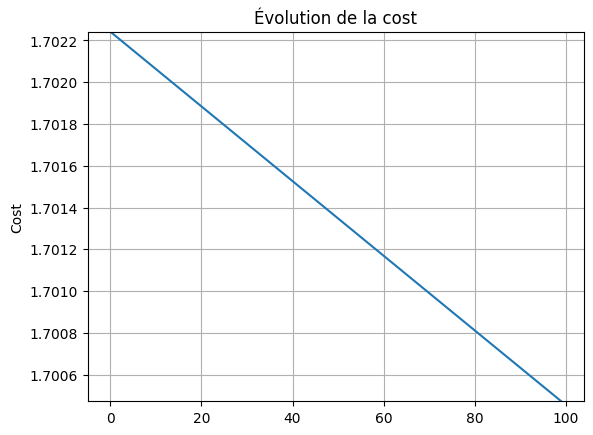

In [122]:
import matplotlib.pyplot as plt

x = [i for i in range(100)]
print(last_cost)
plt.plot(x, last_cost)
plt.ylim(min(last_cost), max(last_cost))
plt.ylabel("Cost")
plt.title("Évolution de la cost")
plt.grid(True)
plt.show()
